## Linear regression

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

### Data preprocessing

In [2]:
df = pd.read_csv('podatki_PM.csv')

print('Null values: \n',df.isnull().sum())
df = df.drop(columns=['Datum'])

df.fillna(df.mean(), inplace=True)

print('Null values: \n',df.isnull().sum())
print('\n')
num_instances, num_features = df.shape
df['PM10'].astype(float) 
print(f"Number of instances: {num_instances}")
print(f"Number of features: {num_features}")


Null values: 
 Datum                         0
Glob_sevanje_mean             0
Hitrost_vetra_mean            0
Sunki_vetra_max               0
Padavine_sum                  0
Vlaga_mean                    0
Temperatura_Krvavec_mean      0
Temperatura_lokacija_mean     0
PM10                          0
PM_vceraj                    33
sinD                          0
cosD                          0
dtype: int64
Null values: 
 Glob_sevanje_mean            0
Hitrost_vetra_mean           0
Sunki_vetra_max              0
Padavine_sum                 0
Vlaga_mean                   0
Temperatura_Krvavec_mean     0
Temperatura_lokacija_mean    0
PM10                         0
PM_vceraj                    0
sinD                         0
cosD                         0
dtype: int64


Number of instances: 1213
Number of features: 11


### Data splitting and target variable selection

In [3]:
y = df['PM10']  
X = df.drop(columns=['PM10'])                
print(f"Range of y (PM10): [{y.min()}-{y.max()}]")

# 70/30 train-test split without random shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_test_s = scaler_X.transform(X_test)

y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten() 
y_test_s = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Range of y (PM10): [1.8-114.9]
Training features shape: (849, 10)
Testing features shape: (364, 10)
Training target shape: (849,)
Testing target shape: (364,)


### Multiple Linear Regression

In [37]:

class MultipleLinearRegression:
    def __init__(self, polynomial_degree=1, log_transform=False, log_attributes=False):
        """
        Initialize the MultipleLinearRegression model.

        Parameters:
        polynomial_degree : int, optional
            The degree of polynomial features to generate (default is 1, which means no polynomial features).
        log_transform : bool, optional
            If True, the target variable will be log-transformed (default is False).
        log_attributes : bool, optional
            If True, the input features will be log-transformed (default is False).
        """
        self.beta = None
        self.polynomial_degree = polynomial_degree
        self.log_transform = log_transform
        self.log_attributes = log_attributes
        self.y_predict = None
        self.residual = None
        
        self.residual_norm = None  
        self.nparams = None
        self.nresids = None  
        self.leverage = None 
        self.cooks_distance = None 


    def fit(self, X, y):
        """
        Fit the model to the given data.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features.
        y : numpy array or pandas Series
            The target variable.

        This method computes the coefficients of the regression model,
        as well as the fitted values, residuals, and diagnostic measures.
        """
        if self.log_transform:
            y = np.log(y)

        if self.log_attributes:
            X = np.log(X)

        if self.polynomial_degree > 1:
            X = self._generate_polynomial_features(X)

        X = np.c_[np.ones(X.shape[0]), X]
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y 

        self.y_predict = X @ self.beta
        self.residual = y - self.y_predict
        self.nparams = X.shape[1]
        self.nresids = X.shape[0]
        self.residual_norm = self.residual / np.std(self.residual)

        self.leverage = self._calculate_leverage(X)
        self.cooks_distance = self._calculate_cooks_distance()
        
       
    def predict(self, X):
        """
        Predict the target variable using the learned coefficients.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features for prediction.

        Returns:
        numpy array
            The predicted values.
        """
        if self.log_attributes:
            X = np.log(X)

        if self.polynomial_degree > 1:
            X = self._generate_polynomial_features(X)

        X = np.c_[np.ones(X.shape[0]), X]  
        predictions = X @ self.beta

        # Reversing logarithmic transformation if it was applied to the target
        if self.log_transform:
            predictions = np.exp(predictions)

        return predictions
        
    def _generate_polynomial_features(self, X):
        """
        Generate polynomial features of the specified degree.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features.

        Returns:
        numpy array
            The input features with added polynomial features.
        """
        X_poly = X.copy()
        for degree in range(2, self.polynomial_degree + 1):
            X_poly = np.c_[X_poly, X ** degree]
        return X_poly


    def _calculate_leverage(self, X):
        """
        Calculate leverage for each observation.

        Leverage measures how much an observation influences the fitted values.

        Parameters:
        X : numpy array
            The input features with a bias term.

        Returns:
        numpy array
            An array of leverage values for each observation.
        """
        # Leverage calculation (H = X(X'X)^(-1)X')
        hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
        return np.diag(hat_matrix)

    def _calculate_cooks_distance(self):
        """
        Calculate Cook's distance for each observation.

        Cook's distance helps identify influential data points that significantly affect the regression results.

        Returns:
        numpy array
            An array of Cook's distance values for each observation.
        """
        residuals_sq = self.residual**2
        return (residuals_sq / (self.nparams * np.var(self.residual))) * (self.leverage / (1 - self.leverage)**2)

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves.

        Parameters:
        factor : float
            A factor used to determine the Cook's distance curve.

        Returns:
        tuple
            Two numpy arrays: x values and corresponding y values for the Cook's distance curve.
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates of the top residuals.

        Parameters:
        quantiles : numpy array
            The theoretical quantiles from the Q-Q plot.
        top_residual_indices : list of int
            Indices of the top residuals.

        Yields:
        tuple
            An index and corresponding x, y coordinates for the Q-Q plot.
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative is None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

    def qq_plot(self, ax=None):
        """
        Standardized Residual vs Theoretical Quantile plot.

        Based on Fox and Weisberg's techniques for checking normality.

        Parameters:
        ax : matplotlib Axes, optional
            The axes on which to plot (default is None, which creates a new figure).

        Returns:
        matplotlib Axes
            The axes containing the Q-Q plot.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # Annotations for top 3 residuals
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot.

        Used to check homoscedasticity of the residuals.
        Based on Fox and Weisberg's methods.

        Parameters:
        ax : matplotlib Axes, optional
            The axes on which to plot (default is None, which creates a new figure).

        Returns:
        matplotlib Axes
            The axes containing the scale-location plot.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5)
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # Annotations for top 3 squared residuals
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$')
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot.

        Based on Fox and Weisberg's methods for identifying influential observations.

        Parameters:
        ax : matplotlib Axes, optional
            The axes on which to plot (default is None, which creates a new figure).
        high_leverage_threshold : bool, optional
            If True, a line indicating high leverage will be added (default is False).
        cooks_threshold : str, optional
            Method to calculate Cook's distance threshold ('baseR', 'convention', 'dof', default is 'baseR').

        Returns:
        matplotlib Axes
            The axes containing the leverage plot.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5)

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # Annotations for top leverage
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color='C3')

        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4 / self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4 / (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage) + 0.01)
        ax.set_ylim(min(self.residual_norm) - 0.1, max(self.residual_norm) + 0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def residual_plot(self, ax=None):
        """
            Create a Residual vs. Fitted Plot.
    
            Parameters:
            ax : matplotlib axes object, optional
                The axes on which to plot (if None, a new figure will be created).
        """
        if ax is None:
            fig, ax = plt.subplots()
    
            sns.residplot(
                x=self.y_predict,
                y=self.residual,
                lowess=True,
                scatter_kws={'alpha': 0.5},
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                ax=ax)
    
            # Annotate top 3 largest residuals
            residual_abs = np.abs(self.residual)
            abs_resid = np.flip(np.argsort(residual_abs), 0)
            abs_resid_top_3 = abs_resid[:3]
            for i in abs_resid_top_3:
                ax.annotate(
                    i,
                    xy=(self.y_predict[i], self.residual[i]),
                    color='C3')
            ax.set_title('Residuals vs Fitted', fontweight="bold")
            ax.set_xlabel('Fitted values')
            ax.set_ylabel('Residuals')
            return ax
     
    def get_coefficients(self):
        """
        Get the learned coefficients of the model.

        Returns:
        numpy array
            The coefficients of the model.
        """
        return self.beta


In [38]:
model = MultipleLinearRegression()
model.fit(X_train, y_train)
y_pred_custom = model.predict(X_train)
print("Calculated coefficients (beta):", model.get_coefficients())

Calculated coefficients (beta): [ 4.64121501e+01  3.25713628e-02 -2.83160750e+00 -9.68148514e-01
 -2.27105425e-01 -2.37595054e-01  4.71115184e-01 -1.18019711e+00
  5.47713643e-01 -2.57394213e+00  1.53883545e+00]


### Test: Compare the manually written linear regression model with the scikit-learn model

In [39]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"R-squared: {r2:.3f}\n")

#### Fit the linear regression model from scikit-learn

In [40]:
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_train)

#### Custom model and scikit-learn model evaluation

In [41]:
evaluate_model(y_train, y_pred_custom, "Custom Multiple Linear Regression")
evaluate_model(y_train, y_pred_sklearn, "Scikit-Learn Linear Regression")

Custom Multiple Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667

Scikit-Learn Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667



#### Coefficient comparison between custom model and scikit-learn linear regression model

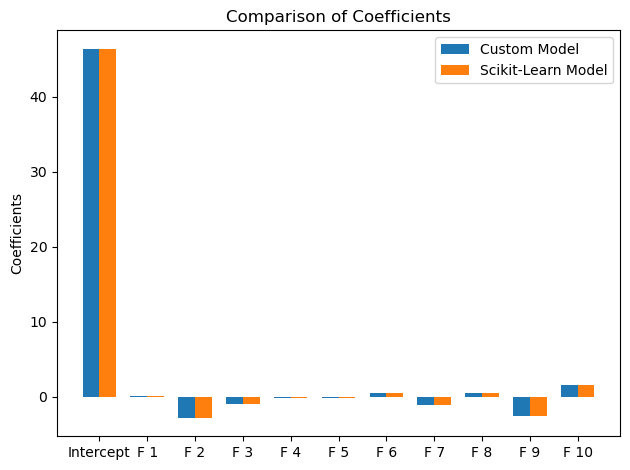

In [42]:
coefficients_custom = model.get_coefficients()
coefficients_sklearn = np.insert(sklearn_model.coef_, 0, sklearn_model.intercept_)

labels = [f'F {i+1}' for i in range(X.shape[1])]
labels = ['Intercept'] + labels

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, coefficients_custom, width, label='Custom Model')
rects2 = ax.bar(x + width/2, coefficients_sklearn, width, label='Scikit-Learn Model')

ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


- The bar chart above compares the coefficients from a custom-built multiple linear regression model to those from the Scikit-Learn implementation of linear regression.
- **Interpretation of Coefficients:**
  - In both models, **the intercept** has the highest positive coefficient, indicating it is the most important predictor in the model. A one-unit increase in the intercept leads to a significant increase in the predicted target variable.
  - **Intercept:** Both models have a similar intercept, which represents the baseline value of the target variable when all feature values are zero.
  - **Other Features (F1 - F10):** The remaining features have relatively small coefficients in both models, suggesting they contribute less to the predictions. Specifically:
    - **Features F2 and F9** have a small, negative coefficient, meaning that as the feature increases, the target variable decreases slightly, though the effect is minimal.
    - Features F3 through F8 have very small coefficients, with values close to zero. This suggests that these features have little to no effect on the model’s predictions.

### Diagnosing the linear regression model with diagnostic plots

#### Residuals vs. Fitted Values Plot
Checking for non-linearity
If there is a clear pattern (such as curves or a U-shape), it indicates non-linearity.

In [43]:
print('Custom Multiple Linear Regression Performance')
residuals = y_train - y_pred_custom

Custom Multiple Linear Regression Performance


In [11]:
# import matplotlib.pyplot as plt
# 
# print('Custom Multiple Linear Regression Performance')
# residuals = y_train - y_pred_custom
# 
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# 
# # Plot for Custom Multiple Linear Regression
# axs[0, 0].scatter(y_pred_custom, residuals, alpha=0.5)
# axs[0, 0].axhline(y=0, color='r', linestyle='--')
# axs[0, 0].set_title('Residuals vs. Fitted Values (Custom)')
# axs[0, 0].set_xlabel('Fitted Values')
# axs[0, 0].set_ylabel('Residuals')
# 
# # Plot for Polynomial Regression
# model_polynomial = MultipleLinearRegression(polynomial_degree=5)
# model_polynomial.fit(X_train, y_train) 
# y_pred_polynomial = model_polynomial.predict(X_train)
# residuals2 = y_train - y_pred_polynomial
# 
# axs[0, 1].scatter(y_pred_polynomial, residuals2, alpha=0.5)
# axs[0, 1].axhline(y=0, color='r', linestyle='--')
# axs[0, 1].set_title('Residuals vs. Fitted Values (Polynomial)')
# axs[0, 1].set_xlabel('Fitted Values')
# axs[0, 1].set_ylabel('Residuals')
# 
# # Plot for Logarithmic Transformation of the Target Variable
# model_log = MultipleLinearRegression(log_transform=True)
# model_log.fit(X_train, y_train)  
# y_pred_log = model_log.predict(X_train) 
# residuals_log = y_train - y_pred_log 
# 
# axs[1, 0].scatter(y_pred_log, residuals_log, alpha=0.5)
# axs[1, 0].axhline(y=0, color='r', linestyle='--')
# axs[1, 0].set_title('Residuals vs. Fitted Values (Log Transformation)')
# axs[1, 0].set_xlabel('Fitted Values')
# axs[1, 0].set_ylabel('Residuals (Log)')
# 
# # Plot for Standardized Target Variable
# model_standardized = MultipleLinearRegression()
# model_standardized.fit(X_train_s, y_train_s)
# y_pred_standardized = model_standardized.predict(X_train_s)
# residuals_standardized = y_train_s - y_pred_standardized
# 
# axs[1, 1].scatter(y_pred_standardized, residuals_standardized, alpha=0.5)
# axs[1, 1].axhline(y=0, color='r', linestyle='--')
# axs[1, 1].set_title('Residuals vs. Fitted Values (Standardized)')
# axs[1, 1].set_xlabel('Fitted Values')
# axs[1, 1].set_ylabel('Residuals (Standardized)')
# 
# plt.tight_layout()
# plt.show()


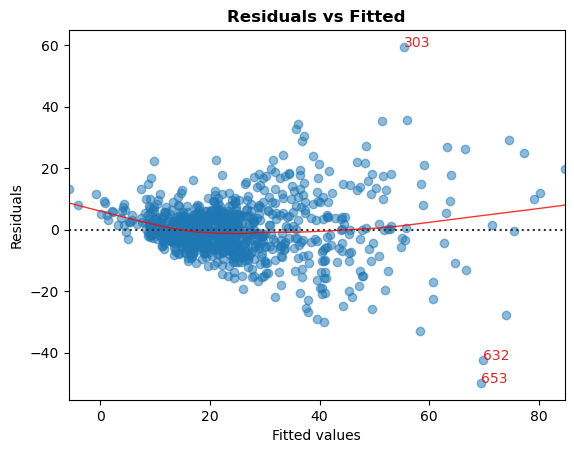

In [44]:
model.residual_plot()
plt.show()

#### Normal Q-Q (Quantile-Quantile) Plot

With this plot we can see whether the dataset follows normal distribution. 

NOTE: A Q-Q plot compares the quantiles of a dataset against the quantiles of a theoretical distribution, which in this case is the normal distribution. If the dataset is normally distributed, the points will fall approximately along a straight line.

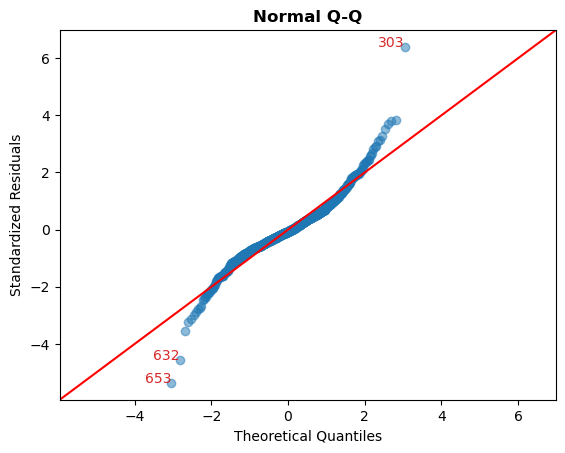

In [45]:
model.qq_plot()
plt.show()

####  Breusch-Pagan Test for Heteroscedasticity

A p-value less than 0.05 suggests heteroscedasticity

In [46]:
bp_test = het_breuschpagan(residuals, np.c_[np.ones(X_train.shape[0]), X_train])
# bp_test returns: (Lagrange Multiplier statistic, p-value, f-value, f p-value)
print(bp_test)
print(f'Breusch-Pagan test p-value: {bp_test[1]}')
if bp_test[1] < 0.05:
    print("The test indicates heteroscedasticity (p < 0.05).")
else:
    print("The test does not indicate heteroscedasticity (p >= 0.05).")

(183.95903511609995, 3.527334675416712e-34, 23.180176796207423, 1.0926041962590453e-38)
Breusch-Pagan test p-value: 3.527334675416712e-34
The test indicates heteroscedasticity (p < 0.05).


### Scale-Location plot

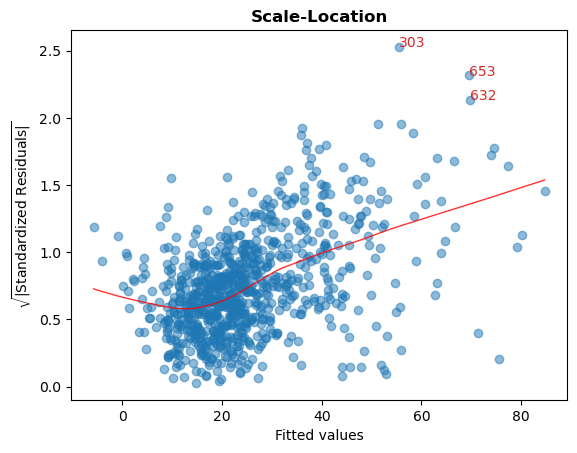

In [48]:
model.scale_location_plot()
plt.show()

### Leverage plot

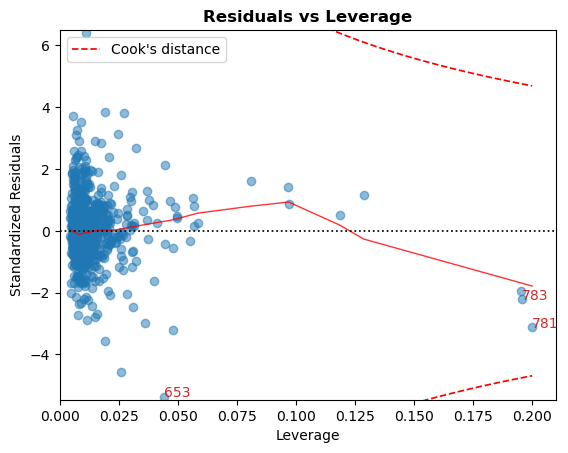

In [49]:
model.leverage_plot()
plt.show()

### Attribute correlation

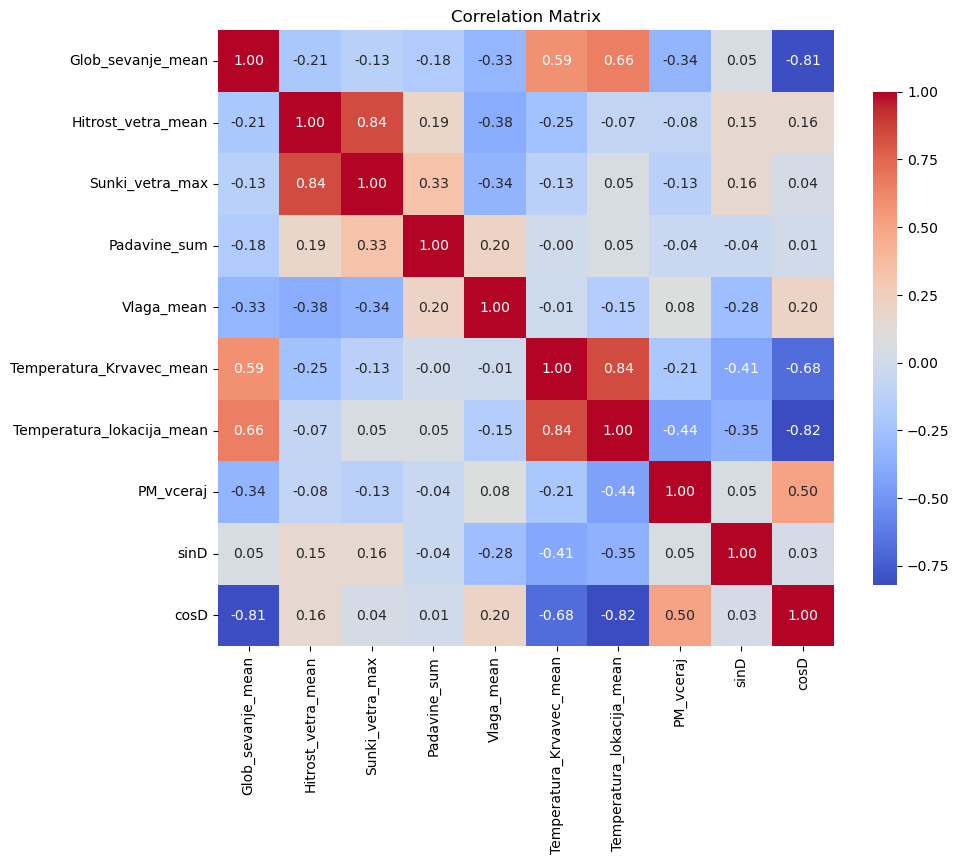

In [55]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')

plt.savefig('images/attribute_correlation.png', bbox_inches='tight') 

plt.show()

## Improvements

In [56]:
evaluate_model(y_train, y_pred_custom, "Custom Multiple Linear Regression")

Custom Multiple Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667



In [61]:
X_filtered = X.drop(columns=['Hitrost_vetra_mean', 'Temperatura_Krvavec_mean'])
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y, test_size=0.3, shuffle=False)

model_filtered = MultipleLinearRegression()
model_filtered.fit(X_train_filtered, y_train_filtered)
y_pred_custom_filtered = model_filtered.predict(X_train_filtered)
print("Calculated coefficients (beta):", model_filtered.get_coefficients())

Calculated coefficients (beta): [38.82472606  0.04422979 -1.8078537  -0.19709613 -0.18457595 -0.77597385
  0.58212866 -2.79392021  1.28235849]


In [65]:
evaluate_model(y_train_filtered, y_pred_custom_filtered, "Custom Multiple Linear Regression Filtered")

Custom Multiple Linear Regression Filtered Performance:
Mean Absolute Error: 6.671
Mean Squared Error: 90.460
R-squared: 0.651



### Polynomial regression

### Logarithmic transformation on target variable

### Logarithmic transformation on the features